# Trend map creation 01/2020
Valentin Dall'Alba / January 2020

In [148]:
#Import packages
import flopy
from flopy.utils.triangle import Triangle as Triangle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gp
import shutil
import pickle

exec(open('./functions/trend_creation_function.py').read())

## 1 : Create the layers from the shp files
We read the shp files and creates layer in shapely format (geopandas)

In [3]:
#Get shp names
trend_path = './shp/trendRGF/'
trend_list = os.listdir(trend_path)
trend_list.sort()
trend_list = trend_list[0:24:2]
trend_list

['1.shp',
 '10.shp',
 '100.shp',
 '110.shp',
 '20.shp',
 '30.shp',
 '40.shp',
 '50.shp',
 '60.shp',
 '70.shp',
 '80.shp',
 '90.shp']

In [4]:
layers = []
for trend in trend_list:
    layer = create_grid(trend_path+trend,plot=False)
    layers.append(layer)

## 2 : Create the triangular meshes
We create the triangular mesh with flopy for each grid previously created.  
(Note thet some geometries are simplified in QGis before the import.)

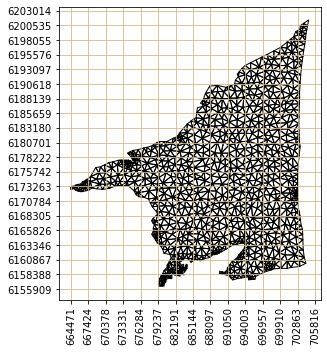

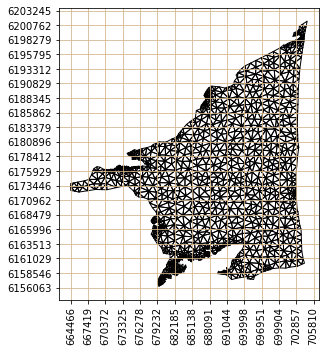

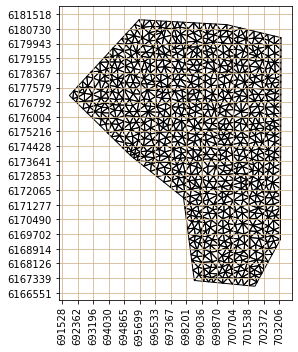

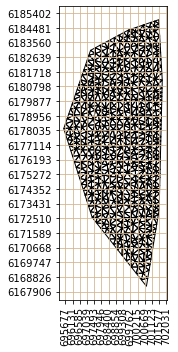

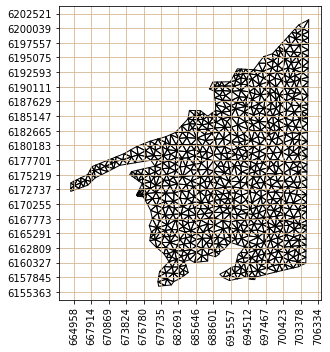

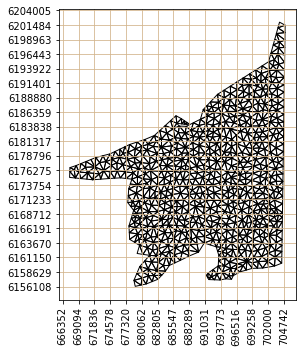

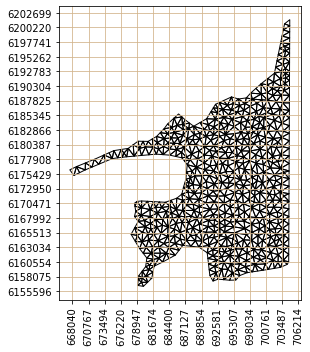

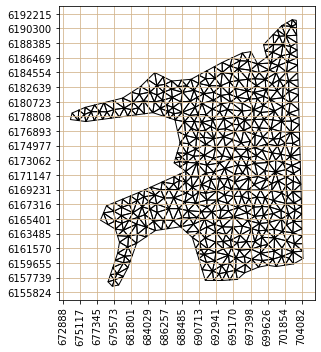

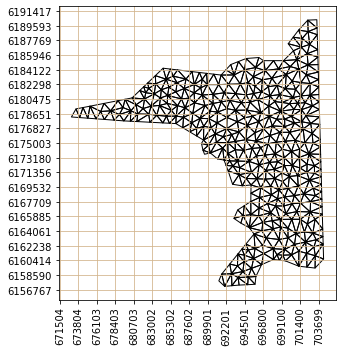

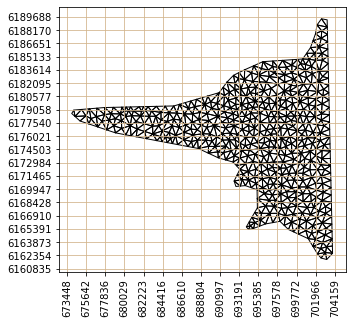

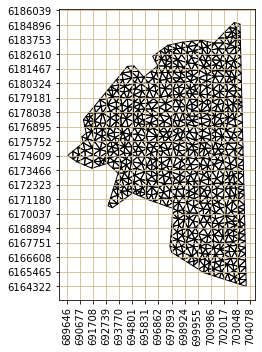

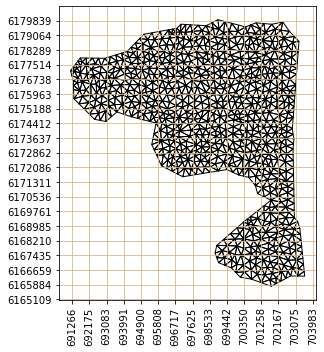

In [11]:
#Max area for triangular cell for each layer
max_area = [1000000, 1000000, 100000, 100000, 1000000, 1000000, 1000000, 1000000, 1000000, 500000, 200000, 100000]
layers_pts, grids = [], []
for i, layer in enumerate(layers):
    layer_pts, grid  = create_mesh(layer, max_area=max_area[i], saveFig=False)
    layers_pts.append(layer_pts)
    grids.append(grid)

## 3 : We define the boundary conditions  
The boundary conditions are setp regarding the coordinates of the edge-cells.

In [12]:
#RGF-93
hd0={1: [[700000,710000,6160967,6300000]],
10: [[700000,710000,6160967,6300000]],
100:[[701700,710000,6160000,6180000]],
110:[[700700,710000,6100000,6184500]],
20: [[703400,710000,6160327,6200000]],
30: [[703000,710000,6100000,6206000]],
40: [[703500,710000,6160500,6203000]],
50: [[703000,710000,6159650,6200000]],
60: [[702500,710000,6100000,6183000]],
70: [[702500,710000,6162000,6200000]],
80: [[703000,710000,6100000,6200000]],
90: [[702800,710000,6100000,6200000]],
}

hd1={1: [[660000,700000,6100000,6180800]],
10: [[660000,700000,6100000,6180800]],
100:[[680000,701700,6100000,6180900]],
110:[[680000,700700,6100000,6183000]],
20: [[660000,703400,6100000,6182000]],
30: [[660000,703000,6100000,6183838]],
40: [[660000,703500,6100000,6182600]],
50: [[670000,703000,6100000,6182700]],
60: [[670000,702500,6100000,6182500]],
70: [[670000,702500,6100000,6180000]],
80: [[670000,703000,6100000,6180400]],
90: [[670000,702800,6100000,6178400]]
}

In [13]:
chlists = []
count = 0
for i, pts in zip(hd0.keys(),layers_pts):
    hdList = [hd0[i],hd1[i]]
    chlist = define_cst_heads(pts, grids[count], zones_list=hdList)
    chlists.append(chlist)
    count +=1

56
202


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


76
295


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


39
61


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


46
44


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


35
109


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


39
81


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


38
94


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


32
78


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


23
60


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


36
67


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


42
59


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


38
79


What is the value of the cst head group 0 ? 0
What is the value of the cst head group 1 ? 1


## 4 : We run the simulation
The simulation of the diffusion equation is run with Modflow 6.  
The simualted gradient is then interpolate on a grid that share the same coordinate and size that the simulation grid.  
We use the transformed grid to cut the inteprolation to the roussillon shape at different layers.

In [201]:
#Import the 3D grid
mask_path = '../../../99_Data/roussillon/grid_mask/grid3D_RGF.pickle'
with open(mask_path,'rb')as file:
    mask3D = pickle.load(file)

In [202]:
#The order in which the Modflow grids are stored
layerList = [0,10,100,110,20,30,40,50,60,70,80,90]

In [149]:
heads  = [] 
trends = []

for i, ch in enumerate(chlists):
    #We extract the corresponding 2D grid from the 3D transformed grid
    mask2D = mask3D.val[1,layerList[i],:,:]
    mask2D = img.Img(nx=mask3D.nx,ny=mask3D.ny,nz=1,
                    ox=mask3D.ox, oy=mask3D.oy, oz=0,
                     sx=100,sy=100,
                    nv=1,val=mask2D)
    
    #We run the mf6 simulation
    run_simulation(grids[i],ch)
    head = get_head(path='./simulation_mf6/', plotFig=False)
    heads.append(head)
    
    #We interpolate the values and create Img object
    trend = mf_to_geone(grids[i], head, mask=mask2D)
    trends.append(trend)

Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True
Simulation is a success ? : True


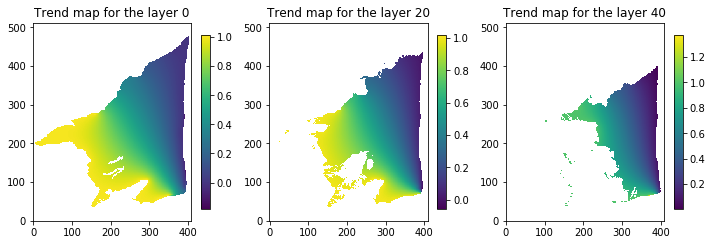

In [180]:
plt.subplots(1,3,figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(trends[0].val[0,0], cmap='viridis', origin='lower')
plt.title('Trend map for the layer 0')
plt.colorbar(shrink=0.25)
plt.tight_layout()

plt.subplot(1,3,2)
plt.imshow(trends[4].val[0,0], cmap='viridis', origin='lower')
plt.title('Trend map for the layer 20')
plt.colorbar(shrink=0.25)
plt.tight_layout()

plt.subplot(1,3,3)
plt.imshow(trends[6].val[0,0], cmap='viridis', origin='lower')
plt.title('Trend map for the layer 40')
plt.colorbar(shrink=0.25)
plt.tight_layout()

## 5 : We create the Img 3D trend object
The 3D trend is created by stacking the trend 0 to the layer 0 to 9, then the trend 1 to the layer 10 to 19...

In [184]:
#We re-arange the order of the img object
#(could be optimized)
layerList   = [0,10,100,110,20,30,40,50,60,70,80,90]
layerSelect = [0,1,4,5,6,7,8,9,10,11,2,3] 
trend_maps  = []
for i in range(len(trends)):
    trend_maps.append(trends[layerSelect[i]])

In [187]:
#We assigne the same trend layer to 10 layers and than choose the next 2D trend
trend_map = np.full((1,125,512,409),np.nan)
for i in range(12):
    for j in range(10):
        trend_map[0,j+i*10,:,:] = trend_maps[i].val[0,0,:,:]

In [186]:
#Import the 3D mask
mask_path = '../../../99_Data/roussillon/grid_mask/grid3D_RGF.pickle'
with open(mask_path,'rb')as file:
    mask3D = pickle.load(file)

In [194]:
#We create the Img object
mask_val = mask3D.val[1:,:125,:,:]
trend_map[mask_val!=1] = np.nan
trendMap = img.Img(nx=409,ny=512,nz=125, 
                sx=100,sy=100,sz=2, 
                ox=mask3D.ox,oy=mask3D.oy,oz=mask3D.oz,
                nv=1,val=trend_map)

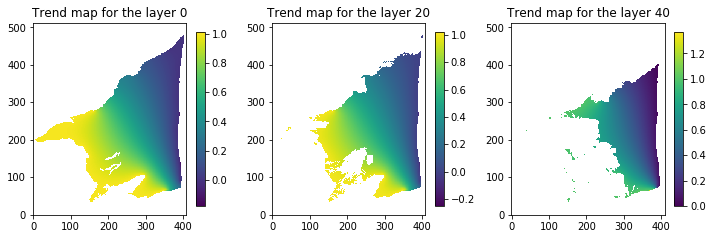

In [196]:
plt.subplots(1,3,figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(trendMap.val[0,0], cmap='viridis', origin='lower')
plt.title('Trend map for the layer 0')
plt.colorbar(shrink=0.25)
plt.tight_layout()

plt.subplot(1,3,2)
plt.imshow(trendMap.val[0,19], cmap='viridis', origin='lower')
plt.title('Trend map for the layer 20')
plt.colorbar(shrink=0.25)
plt.tight_layout()

plt.subplot(1,3,3)
plt.imshow(trendMap.val[0,39], cmap='viridis', origin='lower')
plt.title('Trend map for the layer 40')
plt.colorbar(shrink=0.25)
plt.tight_layout()

In [197]:
#Store the result
with open('../../../99_Data/roussillon/trend_map/trend3D_RGF.pickle','wb')as file:
    pickle.dump(trendMap, file, pickle.HIGHEST_PROTOCOL)